### Data Model for the LILA dataset
The dataset is available on the [site](http://lila.science/datasets)

The bounding box list given in the dataset has the encodings in the form  [x, y, width, height] which is:
- x: xmin
- y: ymin

The standard values needed for tensorflow api can be derived as:
- xmin: x
- ymin: y
- xmax: x+width
- ymax: y+height

Here, we are trying to create a TFRecord file that can be fed into the object deection API

In [1]:
# importing libraries needed to process the lila dataset
import os, sys, csv
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

from sklearn.model_selection import train_test_split # for splitting the data into train and eval

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
"""read the json file from the LILA: Snapshot Serengeti into a dictionary
The dictionary keys are:
annotations: this the bounding box level annotations
images: Information of the image
info: dataset creator information
categories: has a mapping similar to the label map

"""
with open('../data/LILA/SnapshotSerengetiBboxes.json', 'r') as f:
    dict1 = json.load(f)
    
# read the bounding box annotations and the image information to dataframes
df_annotations = pd.DataFrame(dict1['annotations'])
# Removing the unknown category from the dataset
df_annotations = df_annotations.loc[df_annotations['category_id']!=1000]
print(df_annotations.shape)
df_images = pd.DataFrame(dict1['images'])
print(df_images.shape)
df_categories = pd.DataFrame(dict1['categories'])
print(df_categories.shape)
# df_images['image_id'] = df_images['file_name'][:-4]

(100874, 5)
(38380, 11)
(50, 2)


**Checking the contents of the json file**

In [3]:
df_annotations.head()

,bbox,category_id,id,image_id,iscrowd
0,"[214.55868530274304, 626.8372802734388, 199.89...",11,78acdbcc-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN
1,"[704.3220825195315, 685.3982543945319, 160.852...",11,78acdbcd-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN
2,"[1026.6082763671961, 678.6542358398361, 153.12...",11,78acdbce-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN
3,"[1157.5803871154994, 650.5258425474201, 166.77...",11,78acdbcf-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN
4,"[1445.725693901394, 733.3094338575975, 223.270...",11,78acdbd0-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN


In [4]:
df_images.head()

,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,url,width
0,2010-08-04 08:43:14,S1/B05/B05_R1/S1_B05_R1_PICT0056.JPG,0,1536,S1/B05/B05_R1/S1_B05_R1_PICT0056,B05,S1,ASG000000t,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048
1,2010-08-04 08:43:14,S1/B05/B05_R1/S1_B05_R1_PICT0057.JPG,1,1536,S1/B05/B05_R1/S1_B05_R1_PICT0057,B05,S1,ASG000000t,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048
2,2010-08-09 03:08:18,S1/B05/B05_R1/S1_B05_R1_PICT0066.JPG,0,1536,S1/B05/B05_R1/S1_B05_R1_PICT0066,B05,S1,ASG000000y,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048
3,2010-08-09 03:08:18,S1/B05/B05_R1/S1_B05_R1_PICT0067.JPG,1,1536,S1/B05/B05_R1/S1_B05_R1_PICT0067,B05,S1,ASG000000y,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048
4,2010-07-21 05:55:46,S1/B06/B06_R1/S1_B06_R1_PICT0007.JPG,0,1536,S1/B06/B06_R1/S1_B06_R1_PICT0007,B06,S1,ASG0000019,1,https://s3-us-west-2.amazonaws.com/snapshotser...,2048


In [5]:
df_categories.head()

,id,name
0,0,empty
1,1,human
2,2,gazelleGrants
3,3,reedbuck
4,4,dikDik


**Excluding the events that are present in Schneider's data**: This is because Schneider's data is our test data and needs to be of elements that are not seen by the model while training.

In [6]:
df_schneider_box = pd.read_csv('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/GoldStandardBoundBoxCoord.csv')
schneider_events = list(set(df_schneider_box['filename']))
schneider_events = [word.split('.')[0] for word in schneider_events] # [word[:-4] for word in schneider_events]
len(schneider_events)

4011

**Creating the dictionary object that can feed into the function create_tf_example to generate TFRecord object**

In [7]:
"""The function create_tf_example takes in a dictionary as input. 
And so we need to preprocess the LILA dataset into the required format.
This dictionary has the following keys values:
{CaptureEventID: {'metadata' : {"SiteID": val,
                                "DateTime": val, 
                                "Season": val
                                },
                                'images' : [{"Path" : val), #points to the route of image on the disk
                                "URL" : val,
                                "dim_x" : val,
                                "dim_y" : val,
                                "image_label" : "tbd", # This is the image level label if any
                                'observations' : [{'bb_ymin': v['ymin'], 
                                                   'bb_ymax': v['ymax'], 
                                                   'bb_primary_label': v['class'], 
                                                   'bb_xmin': v['xmin'], 
                                                   'bb_xmax': v['xmax'], 
                                                   'bb_label': {"species" : v['class'], 
                                                                "pose" : "standing/ sitting/ running"
                                                                }
                                                   } for k, v in enumerate(gold_standard_bb[row[0]])
                                                   ]}
                               ]}
                                
"""

# Join the tables df_annotations and df_images
df_bb_meta = pd.merge(left=df_annotations, 
                      right=df_images, 
                      how='left',
                      left_on=df_annotations['image_id'], 
                      right_on=df_images['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id_y'])

df_bb_meta = pd.merge(left=df_bb_meta, 
                      right=df_categories, 
                      how='left',
                      left_on=df_bb_meta['category_id'], 
                      right_on=df_categories['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id'])
print("Shape before removing overlapping images with schneider's data: ", df_bb_meta.shape)

# Removing the overlapping images with Schneider's data
df_bb_meta = df_bb_meta[~df_bb_meta['seq_id'].isin(schneider_events)]
print("Shape after removing overlapping images with schneider's data: ", df_bb_meta.shape)


# Converting the dataframe to th dictionary for convenience
dict_bb_meta = df_bb_meta.to_dict('records')

Shape before removing overlapping images with schneider's data:  (100874, 16)
Shape after removing overlapping images with schneider's data:  (100864, 16)


In [22]:
print('Dataframe size of the df_bb_meta is: {0}'.format(df_bb_meta.shape))
df_bb_meta.head(n=2)

Dataframe size of the df_bb_meta is: (100864, 16)


,bbox,category_id,id_x,image_id,iscrowd,datetime,file_name,frame_num,height,location,season,seq_id,seq_num_frames,url,width,name
0,"[214.55868530274304, 626.8372802734388, 199.89...",11,78acdbcc-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN,2010-08-04 08:43:14,S1/B05/B05_R1/S1_B05_R1_PICT0056.JPG,0,1536,B05,S1,ASG000000t,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048,elephant
1,"[704.3220825195315, 685.3982543945319, 160.852...",11,78acdbcd-a4bc-11e8-88e9-000d3a062ba9,S1/B05/B05_R1/S1_B05_R1_PICT0056,NaN,2010-08-04 08:43:14,S1/B05/B05_R1/S1_B05_R1_PICT0056.JPG,0,1536,B05,S1,ASG000000t,2,https://s3-us-west-2.amazonaws.com/snapshotser...,2048,elephant


#### Data Digging & Exploratory Analysis

In [18]:
# Inspecting the dataframe for any corrupt category_id
df_bb_meta[['category_id', 'name']].sort_values(by=['category_id']).drop_duplicates()

,category_id,name
99055,1,human
79161,2,gazelleGrants
86474,3,reedbuck
49516,4,dikDik
67564,5,zebra
12578,6,porcupine
18974,7,gazelleThomsons
5183,8,hyenaSpotted
813,9,warthog
25648,10,impala


In [23]:
df_image_species = df_bb_meta.drop_duplicates(['name', 'file_name'])
df_image_species = df_image_species[['name', 'file_name']]
df_image_species_freq = df_image_species.groupby(by=['name'], as_index=False).count()
df_image_species_freq = df_image_species_freq.sort_values(by='file_name')\
                            .rename(index=str, columns={'file_name':'freq'})

df_image_species_freq['freq_p'] = round((df_image_species_freq['freq']/df_images.shape[0])*100,2)

Text(0.5,0,'% of images out of a total 38380 images')

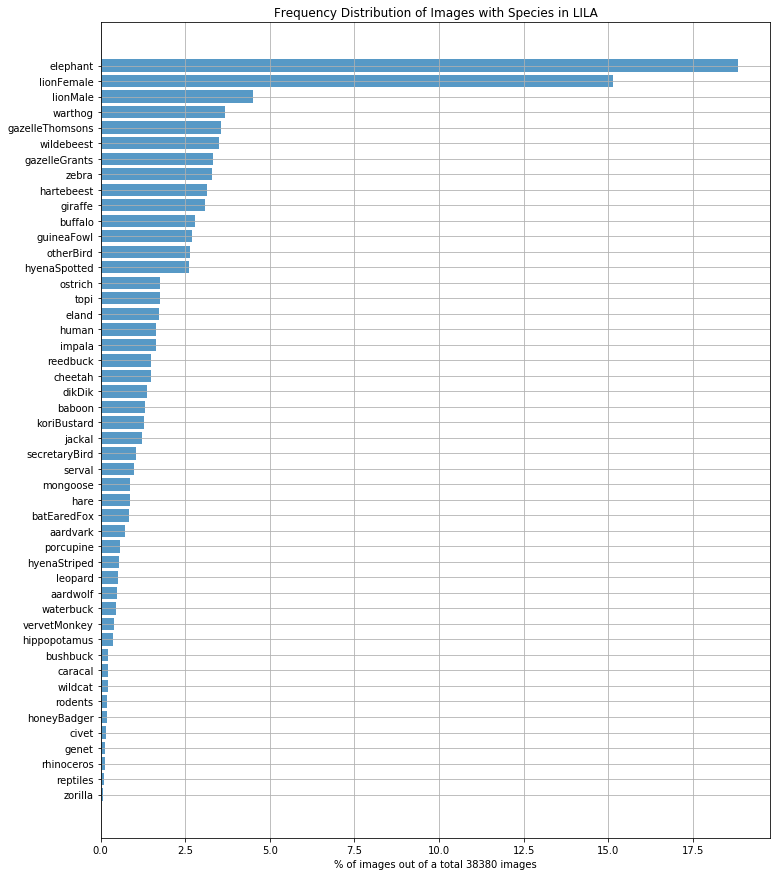

In [24]:
plt.figure(figsize=(12,15))
plt.grid(True)
plt.barh(df_image_species_freq['name'], df_image_species_freq['freq_p'], align='center', alpha=0.75)
plt.title('Frequency Distribution of Images with Species in LILA')
plt.xlabel('% of images out of a total {0} images'.format(df_images.shape[0]))

**Frequency bounding boxes per Species** 

Text(0.5,0,'Number of bounding box in a total 38380 images')

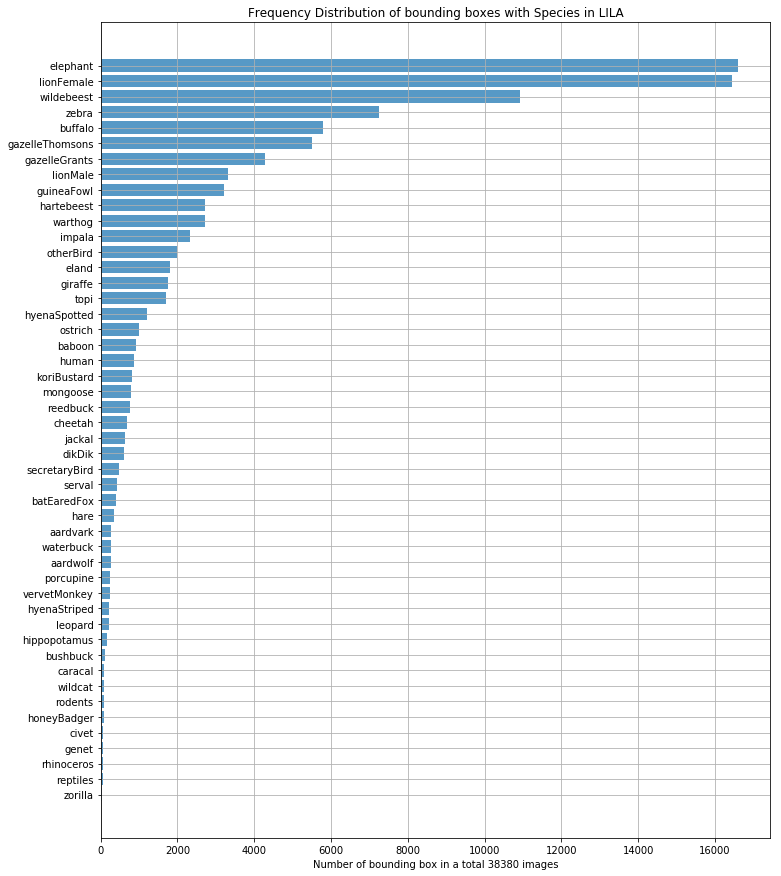

In [25]:
df_bb_species = df_bb_meta.drop_duplicates(['name', 'id_x'])
df_bb_species = df_bb_species[['name', 'id_x']]
df_bb_species_freq = df_bb_species.groupby(by=['name'], as_index=False).count()
df_bb_species_freq = df_bb_species_freq.sort_values(by='id_x')\
                            .rename(index=str, columns={'id_x':'bbox_freq'})

# df_bb_species_freq['bbox_freq_per_image'] = round((df_bb_species_freq['bbox_freq']/df_images.shape[0])*100,2)

plt.figure(figsize=(12,15))
plt.grid(True)
plt.barh(df_bb_species_freq['name'], df_bb_species_freq['bbox_freq'], align='center', alpha=0.75)
plt.title('Frequency Distribution of bounding boxes with Species in LILA')
plt.xlabel('Number of bounding box in a total {0} images'.format(df_images.shape[0]))

In [12]:
l = ['S6/C10/C10_R2/S6_C10_R2_IMAG0146']
l[0].split('/')[-1]

'S6_C10_R2_IMAG0146'

In [13]:
image_path = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/images/'

In [14]:
# This creates a dictionary object here that can be fed into the create_tf_example function. 
# Following the format used in the [previous work]- 
# (https://github.com/Manish-rai21bit/camera-trap-detection/blob/master/Data_Model.ipynb)

# output dictionary will be - event_dict

lst = []
event_dict = {}

for bb_meta in dict_bb_meta:
    if bb_meta['image_id'] not in lst:
        lst.append(bb_meta['image_id'])
        event_dict[bb_meta['image_id']] = {'metadata' : {"SiteID": bb_meta['location'],
                                "DateTime": bb_meta['datetime'], 
                                "Season": bb_meta['season']
                                },
                                'images' : [{"Path" : image_path + bb_meta['file_name'].split('/')[-1], #points to the route of image on the disk
                                "URL" :  bb_meta['url'],
                                "dim_x" :  bb_meta['width'],
                                "dim_y" :  bb_meta['height'],
                                "image_label" : "tbd", # This is the image level label if any
                                'observations' : []
                                            }
                               ]}
        
    event_dict[bb_meta['image_id']]['images'][0]['observations']\
            .append({'bb_ymin': (bb_meta['bbox'][1]), 
                     'bb_ymax':  (bb_meta['bbox'][1] + bb_meta['bbox'][3]*1), 
                     'bb_primary_label':  bb_meta['name'], 
                     'bb_xmin':  (bb_meta['bbox'][0]), 
                     'bb_xmax':  (bb_meta['bbox'][0] + bb_meta['bbox'][2]*1), 
                     'bb_label': {"species" : bb_meta['name'], 
                     "pose" : "standing/ sitting/ running"
                                  }
                    })

### Validation of bounding boxes decoding
**Do visual check on a few images to see if the bounding box encodings are correct**

In [15]:
image_dict = event_dict['S4/I13/I13_R1/S4_I13_R1_IMAG0101']
image_dict

{'images': [{'Path': '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/images/S4_I13_R1_IMAG0101.JPG',
   'URL': nan,
   'dim_x': 2048,
   'dim_y': 1536,
   'image_label': 'tbd',
   'observations': [{'bb_label': {'pose': 'standing/ sitting/ running',
      'species': 'lionFemale'},
     'bb_primary_label': 'lionFemale',
     'bb_xmax': 1857.0,
     'bb_xmin': 2.616694927215576,
     'bb_ymax': 1533.3831787109375,
     'bb_ymin': 1149.0},
    {'bb_label': {'pose': 'standing/ sitting/ running',
      'species': 'lionFemale'},
     'bb_primary_label': 'lionFemale',
     'bb_xmax': 510.41864371299744,
     'bb_xmin': 0,
     'bb_ymax': 1179.6812636852264,
     'bb_ymin': 800.5736403465271}]}],
 'metadata': {'DateTime': '2012-01-01 13:25:48',
  'Season': 'S4',
  'SiteID': 'I13'}}

image width matches the metadata:  True
image height matches the metadata:  True


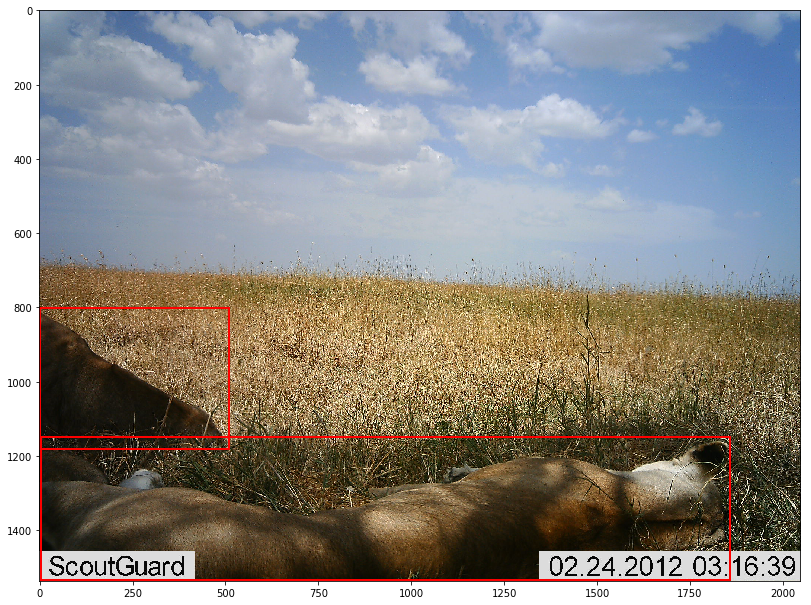

In [16]:
# Testing if the bounding boxes are correct
xmins = []
ymins = []
xmaxs = []
ymaxs = []
i = 0
for bb in image_dict['images'][0]['observations']:
    xmins.append(bb['bb_xmin'])
    ymins.append(bb['bb_ymin'])
    xmaxs.append(bb['bb_xmax'])
    ymaxs.append(bb['bb_ymax'])
        
img = image_dict['images'][0]['Path']
# encoded_jpg_io = io.BytesIO(img)
image = Image.open(img)
width, height = image.size

print("image width matches the metadata: ", image_dict['images'][0]['dim_x'] == width)
print("image height matches the metadata: ",image_dict['images'][0]['dim_y'] == height)

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),abs(xmaxs[s]-xmins[s]), abs(ymaxs[s] - ymins[s]),linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

### Split data into train and val
- event_dict_train : dictionary with traininig data
- event_dict_eval : dictionary with evaluation data

In [17]:
event_dict_train, event_dict_eval = train_test_split(list(event_dict.items()), test_size=0.1, random_state=1)
event_dict_train = dict(event_dict_train)
event_dict_eval = dict(event_dict_eval)

In [19]:
print('training set size: {0}, evaluation set size: {1}'\
      .format(len(list(event_dict_train)), len(list(event_dict_eval))))

training set size: 34379, evaluation set size: 3820


### Create Label_map dictionary

In [27]:
# Uncomment in the below code when creating the label map for the first time

# # the mapping in the label map has to start from 1
# dict1['categories'].pop(0)

# label_map= {}
# label_num = 0
# for lst_element in dict1['categories']:
#     if lst_element['name'] not in label_map:
#         label_map[lst_element['name']] = lst_element['id']
        
# # Creating a json dump for a backup
# with open('../data/LILA/label_map.json', 'w') as outfile:
#     json.dump(label_map, outfile)

# Loading the json dump  
with open('../data/LILA/label_map.json', 'r') as f:
     label_map = json.load(f)
        
# Writing the label map to the pbtxt file
# s = [(k, label_map[k]) for k in sorted(label_map, key=label_map.get, reverse=False)]
# with open('../data/LILA/label_map.pbtxt', 'w') as f:
#     for k, v in s:
#         print("item { \n id:%d \n name:'%s' \n } \n" %(v, k),file=f)

In [28]:
label_map

{'aardvark': 31,
 'aardwolf': 28,
 'baboon': 33,
 'batEaredFox': 23,
 'buffalo': 14,
 'bushbuck': 24,
 'caracal': 45,
 'cheetah': 26,
 'civet': 43,
 'dikDik': 4,
 'eland': 27,
 'elephant': 11,
 'gazelleGrants': 2,
 'gazelleThomsons': 7,
 'genet': 44,
 'giraffe': 12,
 'guineaFowl': 16,
 'hare': 32,
 'hartebeest': 15,
 'hippopotamus': 29,
 'honeyBadger': 40,
 'human': 1,
 'hyenaSpotted': 8,
 'hyenaStriped': 30,
 'impala': 10,
 'jackal': 25,
 'koriBustard': 21,
 'leopard': 18,
 'lionFemale': 20,
 'lionMale': 38,
 'mongoose': 13,
 'ostrich': 19,
 'otherBird': 22,
 'porcupine': 6,
 'reedbuck': 3,
 'reptiles': 47,
 'rhinoceros': 46,
 'rodents': 41,
 'secretaryBird': 36,
 'serval': 37,
 'topi': 39,
 'vervetMonkey': 34,
 'warthog': 9,
 'waterbuck': 35,
 'wildcat': 42,
 'wildebeest': 17,
 'zebra': 5,
 'zorilla': 48}

### Download the images to the local
The image need to be in the local for the encoding to work on it.

Not all the images have an attached url in the event dictionary created above. Therefore, it is a good idea to:
    
    - download the images from the MSI server
    - upload it to the AWS

Future work, setup the pipeline to transfer images from the MSI to AWS and vice-versa

In [22]:
# 1. First task is to get the list of images
# This will essentially be the keys to the event_dict

# The below code creates a list of images that has to be fetched from MSI. I then 
# download the list to local and run the code to fetch the images to local
msi_image_names = list(event_dict.keys())
with open("../data/LILA/msi_image_names.csv",'w') as f:
    wr = csv.writer(f)
    wr.writerow(msi_image_names)

## Create TFRecords
Now that the lila json is decoded and visual checks have been done, I will create the TFRecord files

In [29]:
"""This function reads a raw image, resizes it with aspect ratio preservation and returns the byte string"""
from PIL import Image
import numpy as np
import io



def resize_jpeg(image,  max_side):
    """ Take Raw JPEG resize with aspect ratio preservation
         and return bytes
    """
    img = Image.open(image)
    img.thumbnail([max_side, max_side], Image.ANTIALIAS)
    b = io.BytesIO()
    img.save(b, 'JPEG')
    image_bytes = b.getvalue()
    return image_bytes

In [24]:
""" This function creates a tfrecord example from the dictionary element!"""
def create_tf_example(data_dict):
    #with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
    encoded_jpg = resize_jpeg((data_dict['images'][0]['Path']),  1000)
    #encoded_jpg_io = io.BytesIO(encoded_jpg)
    #image = Image.open(encoded_jpg_io)
    #width, height = image.size
    width = int(data_dict['images'][0]['dim_x'])
    height = int(data_dict['images'][0]['dim_y'])

    filename = data_dict['images'][0]['Path'].encode('utf-8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for bb_record in data_dict['images'][0]['observations']:
        xmins.append(float(bb_record['bb_xmin']) / width)
        xmaxs.append(float(bb_record['bb_xmax']) / width)
        ymins.append(float(bb_record['bb_ymin']) / height)
        ymaxs.append(float(bb_record['bb_ymax']) / height)
        classes_text.append(bb_record['bb_primary_label'].encode('utf8'))
        classes.append(label_map[bb_record['bb_primary_label']])

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    
    return tf_example

"""This iterates over each dictionary item, creates tf examples, 
    serializes the tfrecord examples and writes to a tfrecord file!!!
    As of now, it saves the TFRecord file in the home directory where the code is executed"""
def encode_to_tfr_record(test_feature, out_tfr_file):
    with tf.python_io.TFRecordWriter(out_tfr_file) as writer:
        count = 0
        for k, v in test_feature.items():
            count+=1
            if count%500==0:
                print("processing event number %s : %s" % (count, k))
            example = create_tf_example(v)
            writer.write(example.SerializeToString())
            

### Creating 3 TFRecords:
- Original data (train + eval)
- Training data
- evaluation data

**It is important to know how much time TFRecord creation takes**

In [ ]:
import time
start_time = time.time()
encode_to_tfr_record(event_dict, '../data/LILA/lila.record')
print("--- %s seconds ---" % (time.time() - start_time))

processing event number 500 : S3/I13/I13_R11/S3_I13_R11_IMAG0432
processing event number 1000 : S1/P08/P08_R1/S1_P08_R1_PICT0129
processing event number 1500 : S1/Q08/Q08_R1/S1_Q08_R1_PICT0305
processing event number 2000 : S3/I13/I13_R11/S3_I13_R11_IMAG0439
processing event number 2500 : S1/V13/V13_R1/S1_V13_R1_PICT1765
processing event number 3000 : S2/D05/D05_R1/S2_D05_R1_PICT0336
processing event number 3500 : S5/G01/G01_R3/S5_G01_R3_IMAG0012
processing event number 4000 : S6/D02/D02_R2/S6_D02_R2_IMAG0238
processing event number 4500 : S6/H01/H01_R1/S6_H01_R1_IMAG0142
processing event number 5000 : S1/S12/S12_R1/S1_S12_R1_PICT0180
processing event number 5500 : S1/I13/I13_R1/S1_I13_R1_PICT1684
processing event number 6000 : S4/J02/J02_R1/S4_J02_R1_IMAG1348
processing event number 6500 : S1/P07/P07_R1/S1_P07_R1_PICT0570
processing event number 7000 : S2/G05/G05_R3/S2_G05_R3_IMAG0503
processing event number 7500 : S6/Q13/Q13_R1/S6_Q13_R1_IMAG5927
processing event number 8000 : S5/N06

In [ ]:
# Creating training TFRecord
start_time = time.time()
encode_to_tfr_record(event_dict_train, '../data/LILA/lila_train.record')
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Creating evaluation TFRecord
start_time = time.time()
encode_to_tfr_record(event_dict_eval, '../data/LILA/lila_eval.record')
print("--- %s seconds ---" % (time.time() - start_time))

### Validating the TFRecord by visualizing the image and bounding boxes

This requires decoding the TFRecord file and replotting the image and their bounding boxes for:
- lila.record
- lila_train.record
- lile_eval.record

Inspect the full TFRecord for corrupt instances of class labels

In [39]:
def decode_record(serialized_example):
    context_features = {
                        'image/height': tf.FixedLenFeature([], tf.int64),
                        'image/width': tf.FixedLenFeature([], tf.int64),
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/source_id': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/object/class/text" : tf.VarLenFeature(tf.string),
                        "image/object/class/label" : tf.VarLenFeature(tf.int64)
                    }

#     sequence_features = {
#                          "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
#                          "image/object/class/text" : tf.VarLenFeature(tf.string),
#                          "image/object/class/label" : tf.VarLenFeature(tf.int64)
#                         }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

In [40]:
filename_list = ['../data/LILA/lila.record']
# def create_tfr_reader(filename_list):
#     batch_size = 2
#     num_parallel_calls = 1
#     drop_batch_remainder = False
#     n_repeats = 1
#     is_train = True
#     buffer_size = 1

#     dataset = tf.data.Dataset.from_tensor_slices(filename_list) # creates a dataset with a separate element for each row of the input tensor

#     dataset = dataset.apply(
#             tf.contrib.data.parallel_interleave(
#                 lambda filename: tf.data.TFRecordDataset(filename),
#                 #sloppy=is_train,
#                 cycle_length=1)) #reads the filename as tf record
#     dataset = dataset.prefetch(buffer_size=batch_size)

#     # shuffle records only for training
#     if is_train:
#         dataset.shuffle(buffer_size = buffer_size, reshuffle_each_iteration=True).repeat(count = n_repeats)

#     dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)
 

#     if not is_train:
#         dataset = dataset.repeat(n_repeats)

#     return dataset

In [41]:
# Example for inspecting TFR files
# import matplotlib.pyplot as plt

# dataset = create_tfr_reader(filename_list)

batch_size = 4
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.shuffle(buffer_size=batch_size)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()
        

**Creating the bounding boxes**

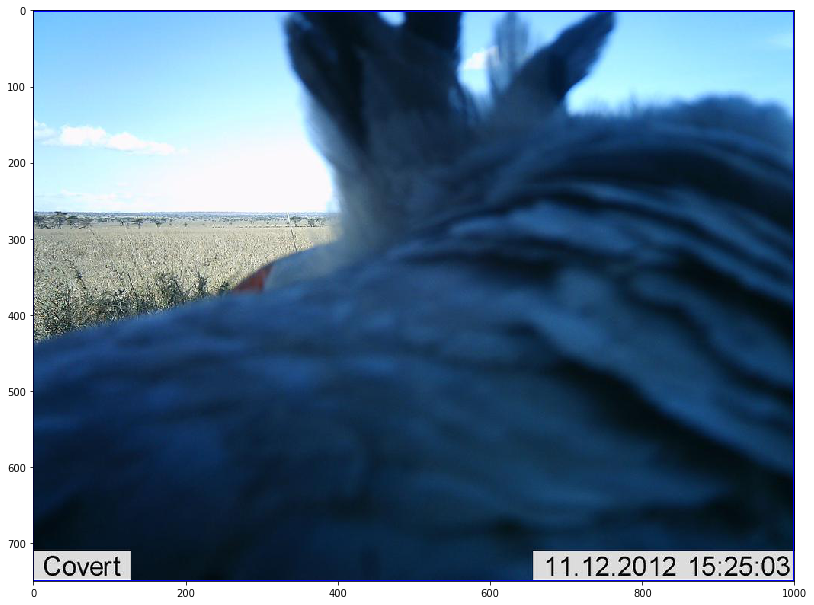

In [42]:
with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        img0 = context['image/encoded'][0]
        xmin = (context['image/object/bbox/xmin'])
        ymin = (context['image/object/bbox/ymin'])
        xmax = (context['image/object/bbox/xmax'])
        ymax = (context['image/object/bbox/ymax'])
        width = context['image/width']
        height = context['image/height']


xmins = []
ymins = []
xmaxs = []
ymaxs = []

img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

i = 0
for j in range(0, xmin[0].shape[0]):
    if xmin[0][j][0] == i:
        xmins.append(int(xmin[1][j]*width))
        ymins.append(int(ymin[1][j]*height))
        xmaxs.append(int(xmax[1][j]*width))
        ymaxs.append(int(ymax[1][j]*height))
        

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), (ymaxs[s] - ymins[s]),linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

**Checking the eval TFRecord**

In [34]:
# Example for inspecting TFR files
# import matplotlib.pyplot as plt

filename_list = ['../data/LILA/lila_eval.record']

batch_size = 4
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.shuffle(buffer_size=batch_size)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()
        

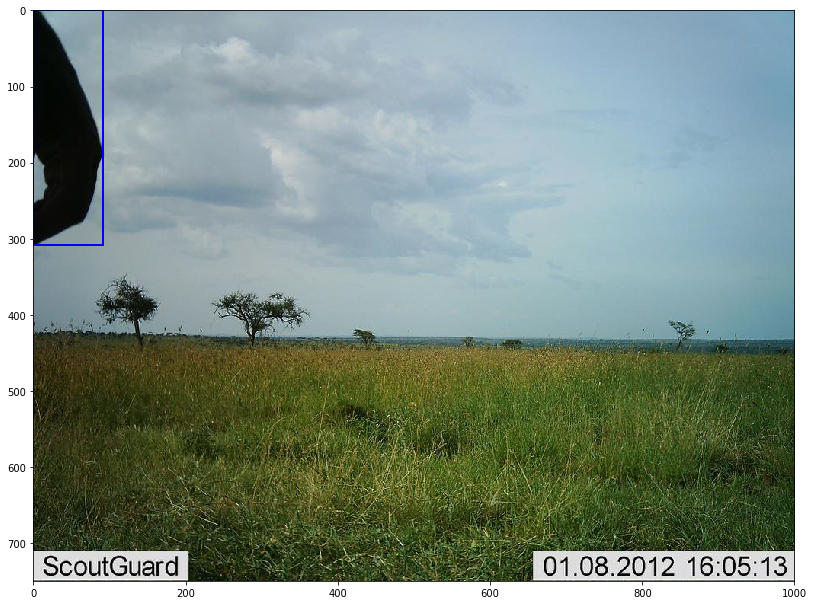

In [35]:
with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        img0 = context['image/encoded'][0]
        xmin = (context['image/object/bbox/xmin'])
        ymin = (context['image/object/bbox/ymin'])
        xmax = (context['image/object/bbox/xmax'])
        ymax = (context['image/object/bbox/ymax'])
        width = context['image/width']
        height = context['image/height']
        

xmins = []
ymins = []
xmaxs = []
ymaxs = []

img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

i = 0
for j in range(0, xmin[0].shape[0]):
    if xmin[0][j][0] == i:
        xmins.append(int(xmin[1][j]*width))
        ymins.append(int(ymin[1][j]*height))
        xmaxs.append(int(xmax[1][j]*width))
        ymaxs.append(int(ymax[1][j]*height))
        

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), (ymaxs[s] - ymins[s]),linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

**Checking the TFRecords for any corrupt category labels**

In [67]:
filename_list = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/lila_train.record'

record_iterator = tf.python_io.tf_record_iterator(path=filename_list)
l1, l2 = [], []
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
  
    l1 = l1 + list(example.features.feature['image/object/class/label'].int64_list.value)
    l2 = l2 + list(example.features.feature['image/object/class/text'].bytes_list.value)
    # Exit after 1 iteration as this is purely demonstrative.

print(sorted(list(set(l1))))
print(sorted(list(set(l2))))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[b'aardvark', b'aardwolf', b'baboon', b'batEaredFox', b'buffalo', b'bushbuck', b'caracal', b'cheetah', b'civet', b'dikDik', b'eland', b'elephant', b'gazelleGrants', b'gazelleThomsons', b'genet', b'giraffe', b'guineaFowl', b'hare', b'hartebeest', b'hippopotamus', b'honeyBadger', b'human', b'hyenaSpotted', b'hyenaStriped', b'impala', b'jackal', b'koriBustard', b'leopard', b'lionFemale', b'lionMale', b'mongoose', b'ostrich', b'otherBird', b'porcupine', b'reedbuck', b'reptiles', b'rhinoceros', b'rodents', b'secretaryBird', b'serval', b'topi', b'vervetMonkey', b'warthog', b'waterbuck', b'wildcat', b'wildebeest', b'zebra', b'zorilla']


In [65]:
print(len(list(set(l1))))
print(len(list(set(l2))))

48
48


**Digging to find why human images still in the json**

In [29]:
df_human = df_bb_meta[df_bb_meta['name']=='human']
df_human = df_human[['file_name', 'name', 'url']].drop_duplicates()
df_human.shape

(629, 3)